## Pre Federated Learning Experiment

We know that our dataset contains images from four different types of devices. Now, consider a scenario where one hospital has only the following device types: **topcon_triton**, **optomed_aurora**, and **topcon_maestro2**, while another hospital uses **icare_eidon**, **topcon_maestro2**, and **optomed_aurora**.

Below, you can see the distribution of device types across different hospitals:

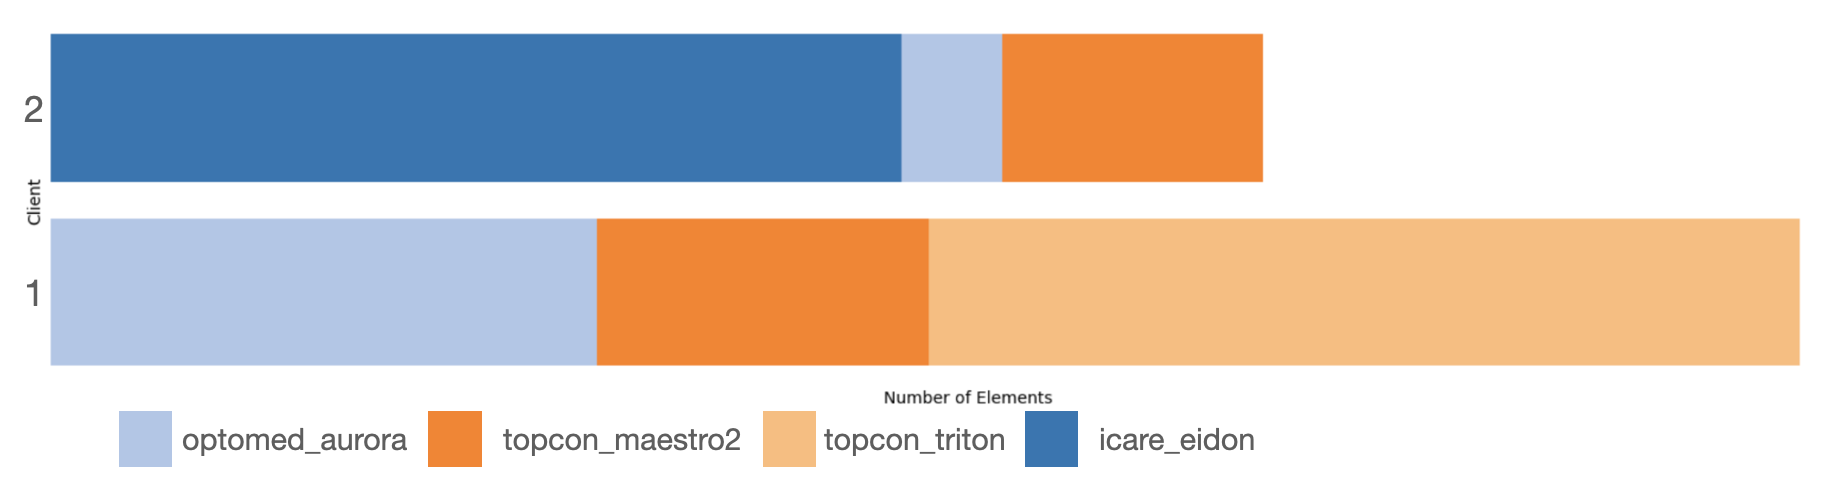

If we train our model solely on data from one hospital — which includes only a subset of device types — the model may not generalize well to unseen devices. For example, if a hospital later adds a new device type that wasn't present in its training data (but exists in another hospital), the model may fail to properly recognize or classify its outputs.

In this section, we will first explore what happens when the model is trained only on data from a single hospital, without incorporating data from other hospitals.

Below is the overall device type distribution in **client1's dataset**:

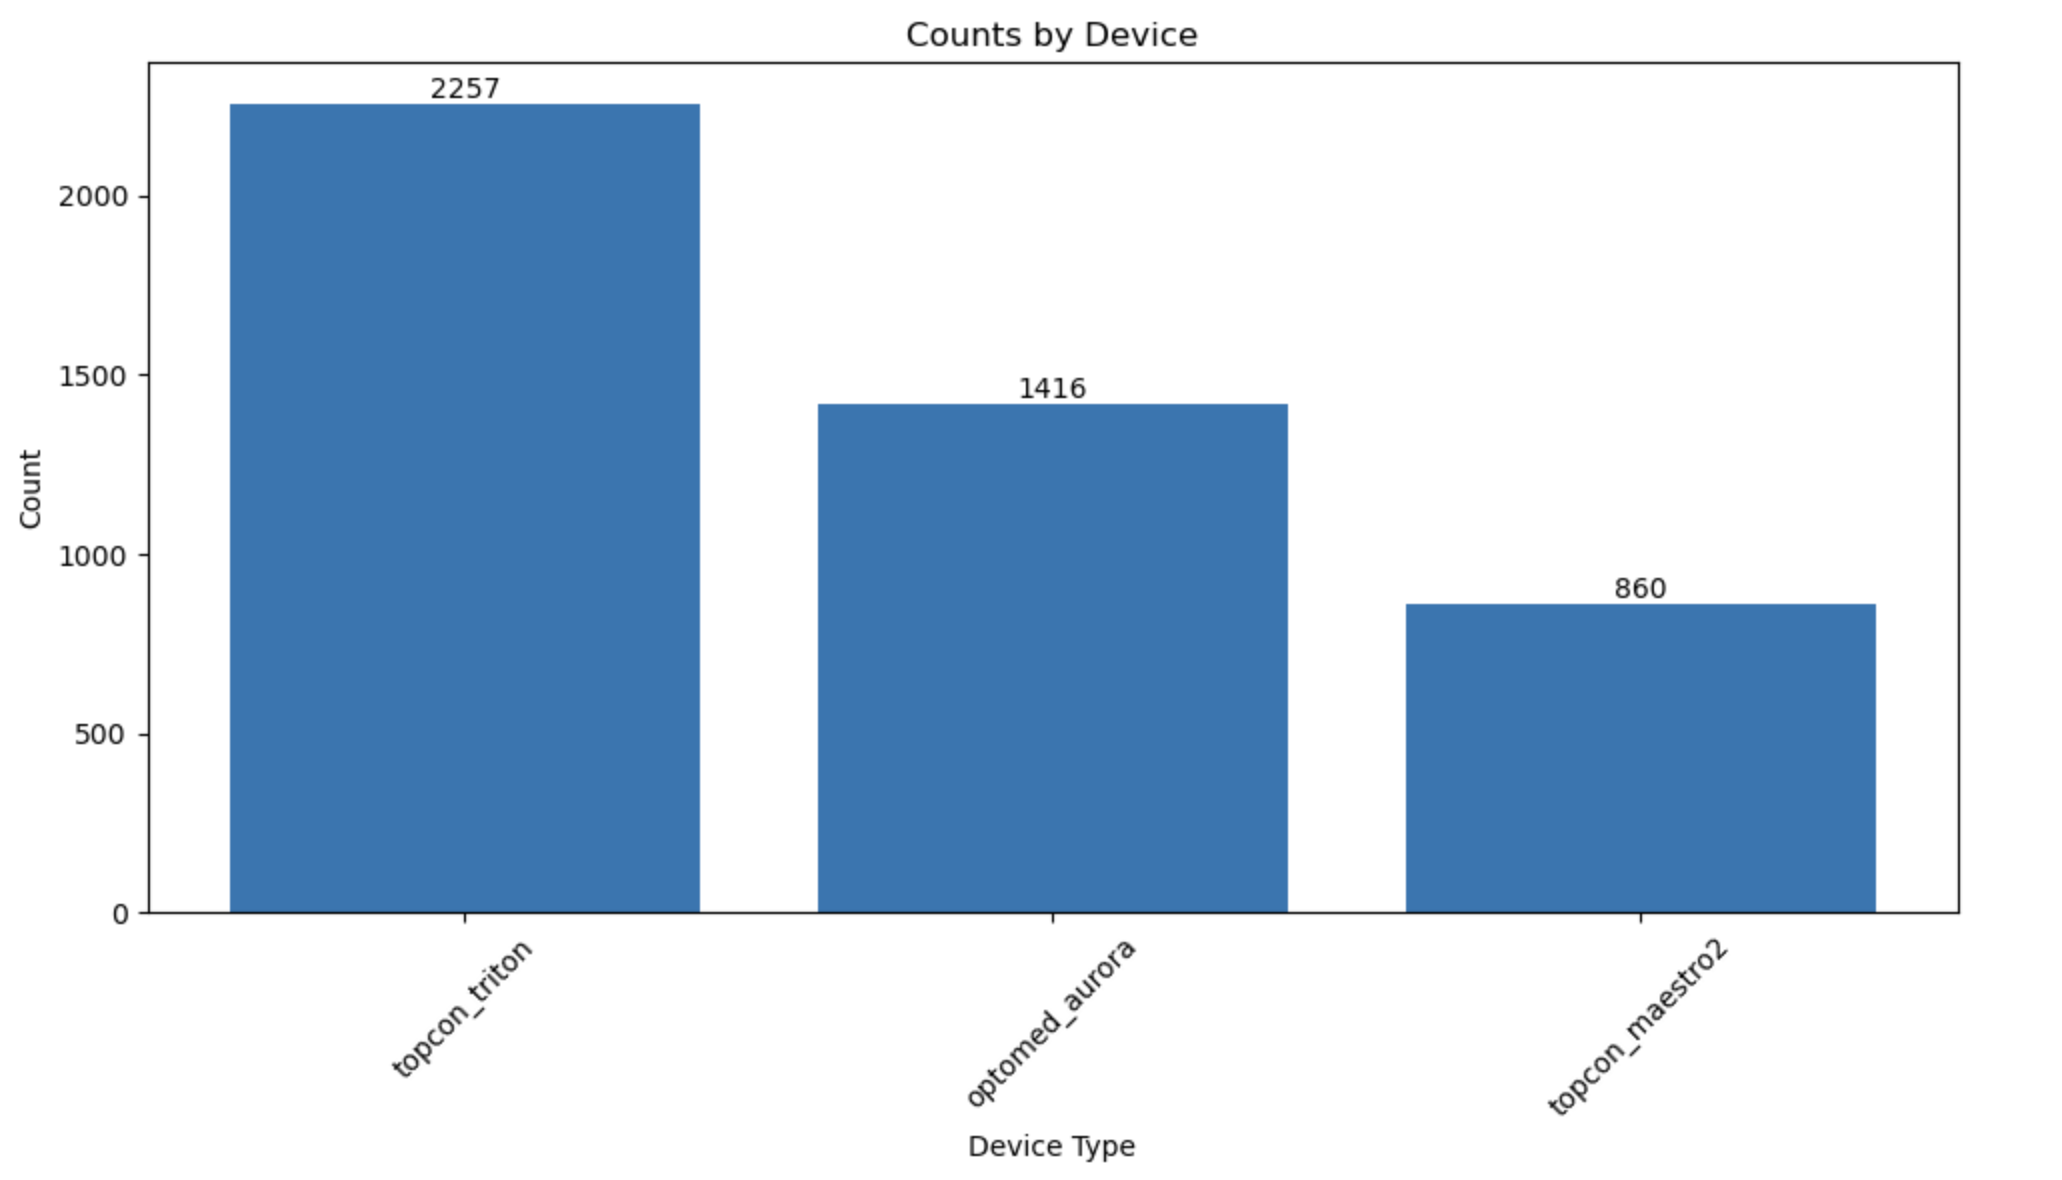

## Load training configuration to train model on client1's data

In [ ]:
import os
import argparse
from omegaconf import OmegaConf
from appfl.agent import ClientAgent
import torchvision.models as models
import torch.nn as nn
import warnings

warnings.filterwarnings('ignore')

os.chdir("/home/jupyter/lab/APPFL/examples")
client_agent_config = OmegaConf.load("./resources/configs/aireadi/client_1_ec2_single.yaml")
client_agent_config.data_configs.dataset_kwargs.visualization = False
print("==========Client Configuration==========")
print(OmegaConf.to_yaml(client_agent_config))
print("========================================")

#### Helper functions for plotting loss and accuracy curves

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display, update_display, HTML
from contextlib import redirect_stdout
import io                                                     # just for capture

def init_plots():
    # Data histories
    round_idx, loss_hist, acc_hist = [], [], []
    log_lines = []

    # Loss Plot
    fig_loss, ax_loss = plt.subplots(figsize=(6, 3))
    ax_loss.set_xticks([])
    ax_loss.set_xlabel("Round")
    ax_loss.set_ylabel("Loss")
    ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
    line_loss, = ax_loss.plot([], [], lw=2)
    fig_loss.tight_layout()

    # Accuracy Plot
    fig_acc, ax_acc = plt.subplots(figsize=(6, 3))
    ax_acc.set_xticks([])
    ax_acc.set_xlabel("Round")
    ax_acc.set_ylabel("Accuracy (%)")
    ax_acc.xaxis.set_major_locator(MaxNLocator(integer=True))
    line_acc, = ax_acc.plot([], [], lw=2, ls='--')
    fig_acc.tight_layout()

    return {
        "round_idx": round_idx,
        "loss_hist": loss_hist,
        "acc_hist": acc_hist,
        "log_lines": log_lines,
        "line_loss": line_loss,
        "line_acc": line_acc,
        "ax_loss": ax_loss,
        "ax_acc": ax_acc,
        "fig_loss": fig_loss,
        "fig_acc": fig_acc,
        "h_loss": None,
        "h_acc": None,
        "h_log": None,
    }


def refresh_plots(state, r, loss, acc):
    state["round_idx"].append(int(r))
    state["loss_hist"].append(loss)
    state["acc_hist"].append(acc)

    state["line_loss"].set_data(state["round_idx"], state["loss_hist"])
    state["line_acc"].set_data(state["round_idx"], state["acc_hist"])

    xmin, xmax = 1, state["round_idx"][-1]
    for ax in (state["ax_loss"], state["ax_acc"]):
        ax.set_xlim(xmin, xmax)
        ax.set_xticks(range(xmin, xmax+1))
        ax.relim()
        ax.autoscale_view(scalex=False, scaley=True)

    update_display(state["fig_loss"], display_id=state["h_loss"].display_id)
    update_display(state["fig_acc"] , display_id=state["h_acc"].display_id)

def flush_log(state, text):
    if text:
        state["log_lines"].append(text.rstrip('\n'))
        html = "<pre style='margin:0'>" + '\n'.join(state["log_lines"]) + "</pre>"
        update_display(HTML(html), display_id=state["h_log"].display_id)


## Train model on Client1's data

In [ ]:
state = init_plots()

state["h_loss"] = display(state["fig_loss"], display_id=True)
state["h_acc"]  = display(state["fig_acc"], display_id=True)
state["h_log"]  = display(HTML("<pre></pre>"), display_id="log")

client_agent = ClientAgent(client_agent_config=client_agent_config)
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 4)
client_agent.load_parameters(model.state_dict())
num_of_epoch = 10
for i in range(0, num_of_epoch):
    buf = io.StringIO()
    with redirect_stdout(buf):
        client_agent.train()
    local_model = client_agent.get_parameters()
    if isinstance(local_model, tuple):
        local_model, metadata = local_model[0], local_model[1]
    else:
        metadata = {}
    flush_log(state, buf.getvalue())
    refresh_plots(state, metadata["round"], metadata["pre_val_loss"], metadata["pre_val_accuracy"])

## Understanding from above experiment

What if both hospitals were able to collaborate to train a model? It would likely result in a better-generalized model. However, sharing hospital data is not that simple due to privacy, security, and regulatory concerns. This is where Federated Learning comes into play — it allows institutions to collaboratively train a model without actually sharing their data.

# Federated Learning Tutorial: Launching the Client 1

<img src="https://github.com/APPFL/APPFL/blob/main/docs/_static/logo/logo_small.png?raw=true" width="40%" alt="APPFL Logo">

In this tutorial, we will leverage the Advanced Privacy-Preserving Federated Learning ([APPFL](https://github.com/APPFL/APPFL)) framework to launch a federated learning client for running a federated learning experiment with two clients and one central server. The server launching code is available in your workspace as **APPFL_Server_AI_READI.ipynb**, also at [here](https://github.com/AdioosinUIUC/arvo-course/blob/main/APPFL_Server_AI_READI.ipynb). Please make sure you first launch the server before launching this client.

This example will train a simple ResNet using the AI-READI dataset partitioned into two cleint splits in a federated manner to predict the device of the collected images.



## 0. Introduction to Federated Learning

As shown in the figure below, federated learning can be understood as a distributed version of traditional machine by iterating the following two steps after a model initialization step

(1) Each client trains an ML model using its local dataset and submits the updated model to the server.

(2) The server aggregates these local models to update the global model and then sends it back to the clients for further local training.

As only model parameters are exchanged, federated learning offers a promising solution to utilize data from multiple data owners without direct data sharing, and it can usually help with training more robust, generalized, and powerful model by leveraging more training data.

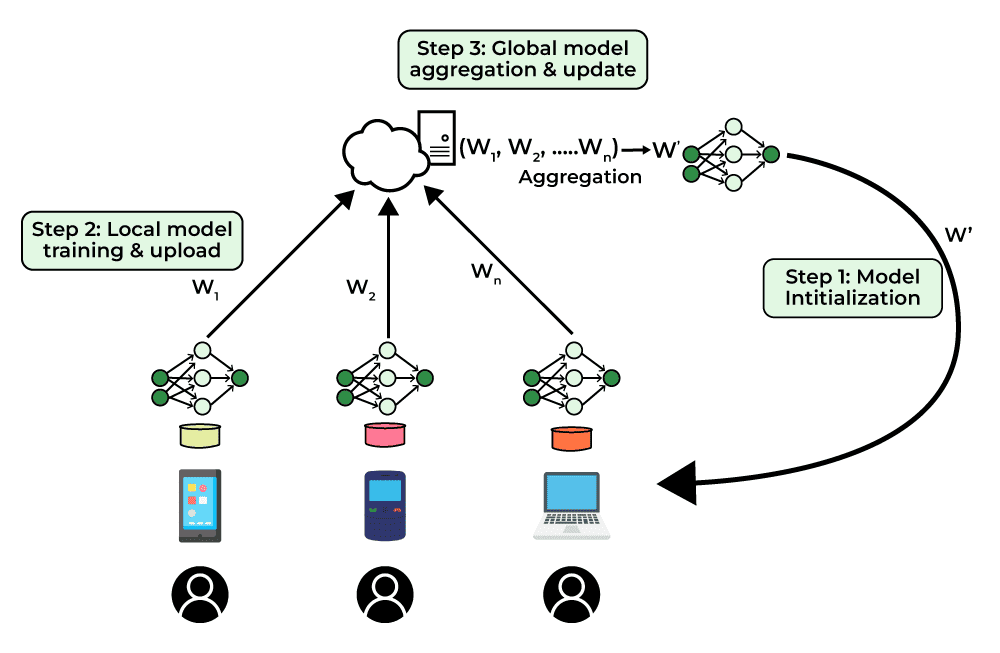

## 1. Install `appfl`

User needs to first install the `appfl` package by the following commands. Since we already have APPFL installed in our workspacewe will skip it.

`pip install appfl`

## 2. Set working directory

In [ ]:
import os

# setting the current working directory
target_directory = '/home/jupyter/lab/APPFL/examples'

os.chdir(target_directory)

## 3. Create federated learning client agent from configurations

We need to update the `server_uri` to the URL obtained from the **server** notebook.

#### Steps:

- ##### Obtain the `server` URL:
  - For example, the server URL from the server notebook is `172.31.79.131:50051`.

- ##### Update the code:
  - Replace the placeholder in the following line with the actual `server` URL obtained.

  - Update the code as follows:
`client_agent_config.comm_configs.grpc_configs["server_uri"] = "172.31.79.131:50051"`

In the client configurations, it has four main parts:

- `client_id`: A unique identifier for the client
- `train_configs`: Client-specific training related configruations, such as the device and logging directories
- `data_configs`: Information about the dataloader file that can create a PyTorch dataset for the AI-READI data
- `comm_configs`: Information needed to connect to the server notebook


In [ ]:
from omegaconf import OmegaConf
from appfl.agent import ClientAgent
client_agent_config = OmegaConf.load("./resources/configs/aireadi/client_1_ec2.yaml")

## update URL here from server notebook
client_agent_config.comm_configs.grpc_configs["server_uri"] = "172.31.69.116:50051" # Reminder: Replace this with the URI you got from the server notebook!
print("==========Client Configuration==========")
print(OmegaConf.to_yaml(client_agent_config))
print("========================================")
client_agent = ClientAgent(client_agent_config=client_agent_config)

## 4. Visualizing the data distribution

Here we see the data distribution on each device type that is being used for the training

In [ ]:
import matplotlib.pyplot as plt

plt.clf()        # Clears the current figure
plt.close('all') # Closes all open figures (optional but safe)

train_distribution = client_agent.train_dataset.label_counts()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(train_distribution.keys(), train_distribution.values())

plt.xlabel('Device Type')
plt.ylabel('Count')
plt.title('Counts by Device')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.show()

## 5. Create Client Communicator

Now, we create a grpc client communicator for sending various requests to the server.

In [ ]:
from appfl.comm.grpc import GRPCClientCommunicator

client_communicator = GRPCClientCommunicator(
    client_id=client_agent.get_id(),
    **client_agent_config.comm_configs.grpc_configs,
)

## 6. Start training loop by sending requests to server.

In this main training loop, it has four main types of request to send to the server:

(1) `get_configuration()`: Get general client configurations for local training

(2) `get_global_model(init_model=True)`: Get the initial global model for training

(3) `update_global_model()`: Send the trained local model to update the global model, and get the updated model back for further local training

(4) `invoke_custom_action(action="close_connection")`: Close the connection with the server

In [ ]:
state = init_plots()

state["h_loss"] = display(state["fig_loss"], display_id=True)
state["h_acc"]  = display(state["fig_acc"], display_id=True)
state["h_log"]  = display(HTML("<pre></pre>"), display_id="log")

# Get general client configurations
client_config = client_communicator.get_configuration()
client_agent.load_config(client_config)

# Get initial global model parameters
init_global_model = client_communicator.get_global_model(init_model=True)
client_agent.load_parameters(init_global_model)

# Start local training loop
while True:
    buf = io.StringIO()
    with redirect_stdout(buf):
        client_agent.train()
    local_model = client_agent.get_parameters()
    if isinstance(local_model, tuple):
        local_model, metadata = local_model[0], local_model[1]
    else:
        metadata = {}
    flush_log(state, buf.getvalue())
    refresh_plots(state, metadata["round"], metadata["pre_val_loss"], metadata["pre_val_accuracy"])
    new_global_model, metadata = client_communicator.update_global_model(
        local_model, **metadata
    )
    if metadata["status"] == "DONE":
        break
    client_agent.load_parameters(new_global_model)

# Close connection
client_communicator.invoke_custom_action(action="close_connection")